In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
cudnn.benchmark = True

In [142]:
content_layers = ['r4_2']
style_layers = ['r1_1','r2_1','r3_1','r4_1','r5_1']

content_im_path = '/content/drive/My Drive/style-transfer/content_image.jpeg'
style_im_path = '/content/drive/My Drive/style-transfer/starry_night.jpeg'

content_weight = 10 #5
style_weight = 9000 #500

im_size = 512
dtype = torch.cuda.FloatTensor
normalize_stats = ([103.939, 116.779, 123.68], [1,1,1])
# 1_1 1_2      2_1. 2_2.      3_1. 3_2. 3_3. 3_4.      4_1. 4_2  4_3. 4_4.      5_1. 5_2. 5_3. 5_4.  
# 64, 64, 'P', 128, 128, 'P', 256, 256, 256, 256, 'P', 512, 512, 512, 512, 'P', 512, 512, 512, 512, 'P'
channels = [64, 64, 'P', 128, 128, 'P', 256, 256, 256, 256, 'P', 512, 512, 512, 512, 'P', 512, 512, 512, 512, 'P']

In [11]:
class GramMatrix(nn.Module):
  def forward(self, x):
    B, C, H, W = x.size() # here B must be 1 
    f = x.view(C, H * W) # row -> channel, columns -> individual activation laid out horizontally
    G = torch.mm(f, f.t())
    return G.div(f.nelement())

In [134]:
class VGG19(nn.Module):
  def __init__(self):
    super(VGG19, self).__init__()
    in_channels, block_number, layer_number = 3,1,1
    self.mode = 'capture'
    self.targets, self.losses = [{l_name: torch.empty(0) for l_name in content_layers+style_layers} for i in range(2)]
  
    layers = []
    for c in channels:
      if c == 'P':
        pool = nn.AvgPool2d(kernel_size=2, stride=2)
        layers.append(pool)
        block_number+=1
        layer_number=1
      else:
        layer_name = f"r{block_number}_{layer_number}"
        conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, stride = 1, padding = 1)
        relu = nn.ReLU(inplace=True)
        if layer_name in content_layers:
          relu.register_forward_hook(self.capture_loss_hook(layer_name, True))
        elif layer_name in style_layers:
          relu.register_forward_hook(self.capture_loss_hook(layer_name, False))
        layers += [conv2d,relu]
        in_channels = c
        layer_number+=1 
    self.features = nn.Sequential(*layers, nn.AdaptiveAvgPool2d(output_size=(7,7)), nn.Flatten())
    self.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(4096, 1000),
    )
    
  def capture_loss_hook(self, layer_name, is_content_loss):
       def fn(module, _ ,output):
         if self.mode == 'content' and is_content_loss:
           self.targets[layer_name] = output.detach()
         elif self.mode == 'style' and not is_content_loss:
           self.targets[layer_name] = output.detach()
         elif self.mode == 'loss':
           target = self.targets[layer_name]
           if is_content_loss:
             self.losses[layer_name] = nn.MSELoss()(output, target)
           else:
             G = GramMatrix()
             self.losses[layer_name] = nn.MSELoss()(G(output), G(target))
       return fn

  def forward(self, x):
     out = self.features(x)
     out = self.classifier(out)
     return out

In [102]:
def preprocess(img_path, im_size):
  image = Image.open(img_path).convert('RGB')
  if type(im_size) is not tuple:
    im_size = tuple([int(im_size/max(image.size) * dim) for dim in (image.height, image.width)])
  tfms = transforms.Compose([
      transforms.Resize(im_size),
      transforms.ToTensor(),
      transforms.Lambda(lambda x: x.mul_(255)),
      transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]),
      transforms.Normalize(*normalize_stats)
  ])
  return tfms(image)[None,:,:,:] # same as unsqueeze(0)

In [6]:
def get_model():
    vgg = VGG19()
    vgg19_pretrained = torch.hub.load('pytorch/vision:v0.9.0', 'vgg19', pretrained=True)
    vgg.load_state_dict(vgg19_pretrained.state_dict())
    return vgg

In [50]:
def setup_optim(img):
   optim = torch.optim.LBFGS([img])
   return optim

In [135]:
def neural_transfer():
  model = get_model()
  model.cuda()

  content_tens, style_tens = preprocess(content_im_path, im_size).type(dtype), preprocess(style_im_path, im_size).type(dtype)

  model.mode = 'content'
  model(content_tens) # capture losses

  model.mode = 'style'
  model(style_tens) # capture styles

  model.mode = 'loss'

  for param in model.parameters():
    param.requires_grad = False

  img = nn.Parameter(torch.randn(content_tens.shape).mul(0.001).type(dtype), requires_grad=True)
  optim = setup_optim(img)
  num_steps = 1000
  run = [0]

  def closure():
    run[0] += 1

    optim.zero_grad()

    model(img)

    style_loss = 0
    content_loss = 0

    for style_layer in style_layers:
      style_loss += model.losses[style_layer]
    for content_layer in content_layers:
      content_loss += model.losses[content_layer]

    style_loss *= style_weight
    content_loss *= content_weight
    loss = style_loss + content_loss
    loss.backward()

    if run[0] % 50 == 0:
      print(f"Iteration {run[0]} / {num_steps}")
      print(f"Style loss: {style_loss} Content loss: {content_loss}")

    return loss


  while run[0] <= num_steps:
    optim.step(closure)
  
  return img 

In [133]:
def imshow(img):
  img = img.data[0].cpu()
  tfms = transforms.Compose([
    transforms.Normalize(mean=[-103.939, -116.779, -123.68], std=[1,1,1]),
    transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]),
  ])
  img = tfms(img) / 255
  img.clamp_(0,1)
  img = img.permute(1,2,0)
  plt.imshow(img)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


Iteration 50 / 1000
Style loss: 8478957.0 Content loss: 9394.572265625
Iteration 100 / 1000
Style loss: 41085.6015625 Content loss: 13401.1767578125
Iteration 150 / 1000
Style loss: 3508.52685546875 Content loss: 9815.7607421875
Iteration 200 / 1000
Style loss: 1839.2802734375 Content loss: 7744.66748046875
Iteration 250 / 1000
Style loss: 1462.01708984375 Content loss: 6579.2685546875
Iteration 300 / 1000
Style loss: 1312.70361328125 Content loss: 5860.08349609375
Iteration 350 / 1000
Style loss: 1245.4091796875 Content loss: 5359.9833984375
Iteration 400 / 1000
Style loss: 1206.0198974609375 Content loss: 4993.431640625
Iteration 450 / 1000
Style loss: 1179.2764892578125 Content loss: 4704.1484375
Iteration 500 / 1000
Style loss: 1166.5716552734375 Content loss: 4484.86865234375
Iteration 550 / 1000
Style loss: 1156.0010986328125 Content loss: 4318.17138671875
Iteration 600 / 1000
Style loss: 1145.3011474609375 Content loss: 4183.8583984375
Iteration 650 / 1000
Style loss: 1138.24584

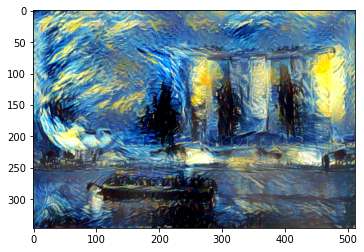

In [143]:
img = neural_transfer()
imshow(img)